<a href="https://colab.research.google.com/github/Aruni20p/Crop_Yied_Prediction_model_61/blob/main/Yield_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Problem Formulation
The goal is to predict crop yield based on various factors like crop type, area, production, rainfall, fertilizer, and pesticide usage.

In [ ]:
# importing important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, HalvingRandomSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error, median_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
from sklearn.neighbors import KNeighborsRegressor
from tabulate import tabulate

### 2. Data Acquisition

In [ ]:
# importing dataset
df = pd.read_csv('crop_yield.csv')

### 3. Data Preprocessing

In [ ]:
df.dropna(inplace=True)

In [ ]:
#checking if there any null values
df.isnull().sum()

,0
Crop,0
Crop_Year,0
Season,0
State,0
Area,0
Production,0
Annual_Rainfall,0
Fertilizer,0
Pesticide,0
Yield,0


In [ ]:
#filtering the data and eliminating outliers
new_df= df[df['Area']>=1000]
new_df= new_df[new_df['Production']>=1000]
new_df= new_df[new_df['Pesticide']>=1000]
new_df= new_df[new_df['Fertilizer']>=1000]
len(new_df)

12234

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12234 entries, 0 to 19688
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Crop             12234 non-null  object 
 1   Crop_Year        12234 non-null  int64  
 2   Season           12234 non-null  object 
 3   State            12234 non-null  object 
 4   Area             12234 non-null  float64
 5   Production       12234 non-null  int64  
 6   Annual_Rainfall  12234 non-null  float64
 7   Fertilizer       12234 non-null  float64
 8   Pesticide        12234 non-null  float64
 9   Yield            12234 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 1.0+ MB


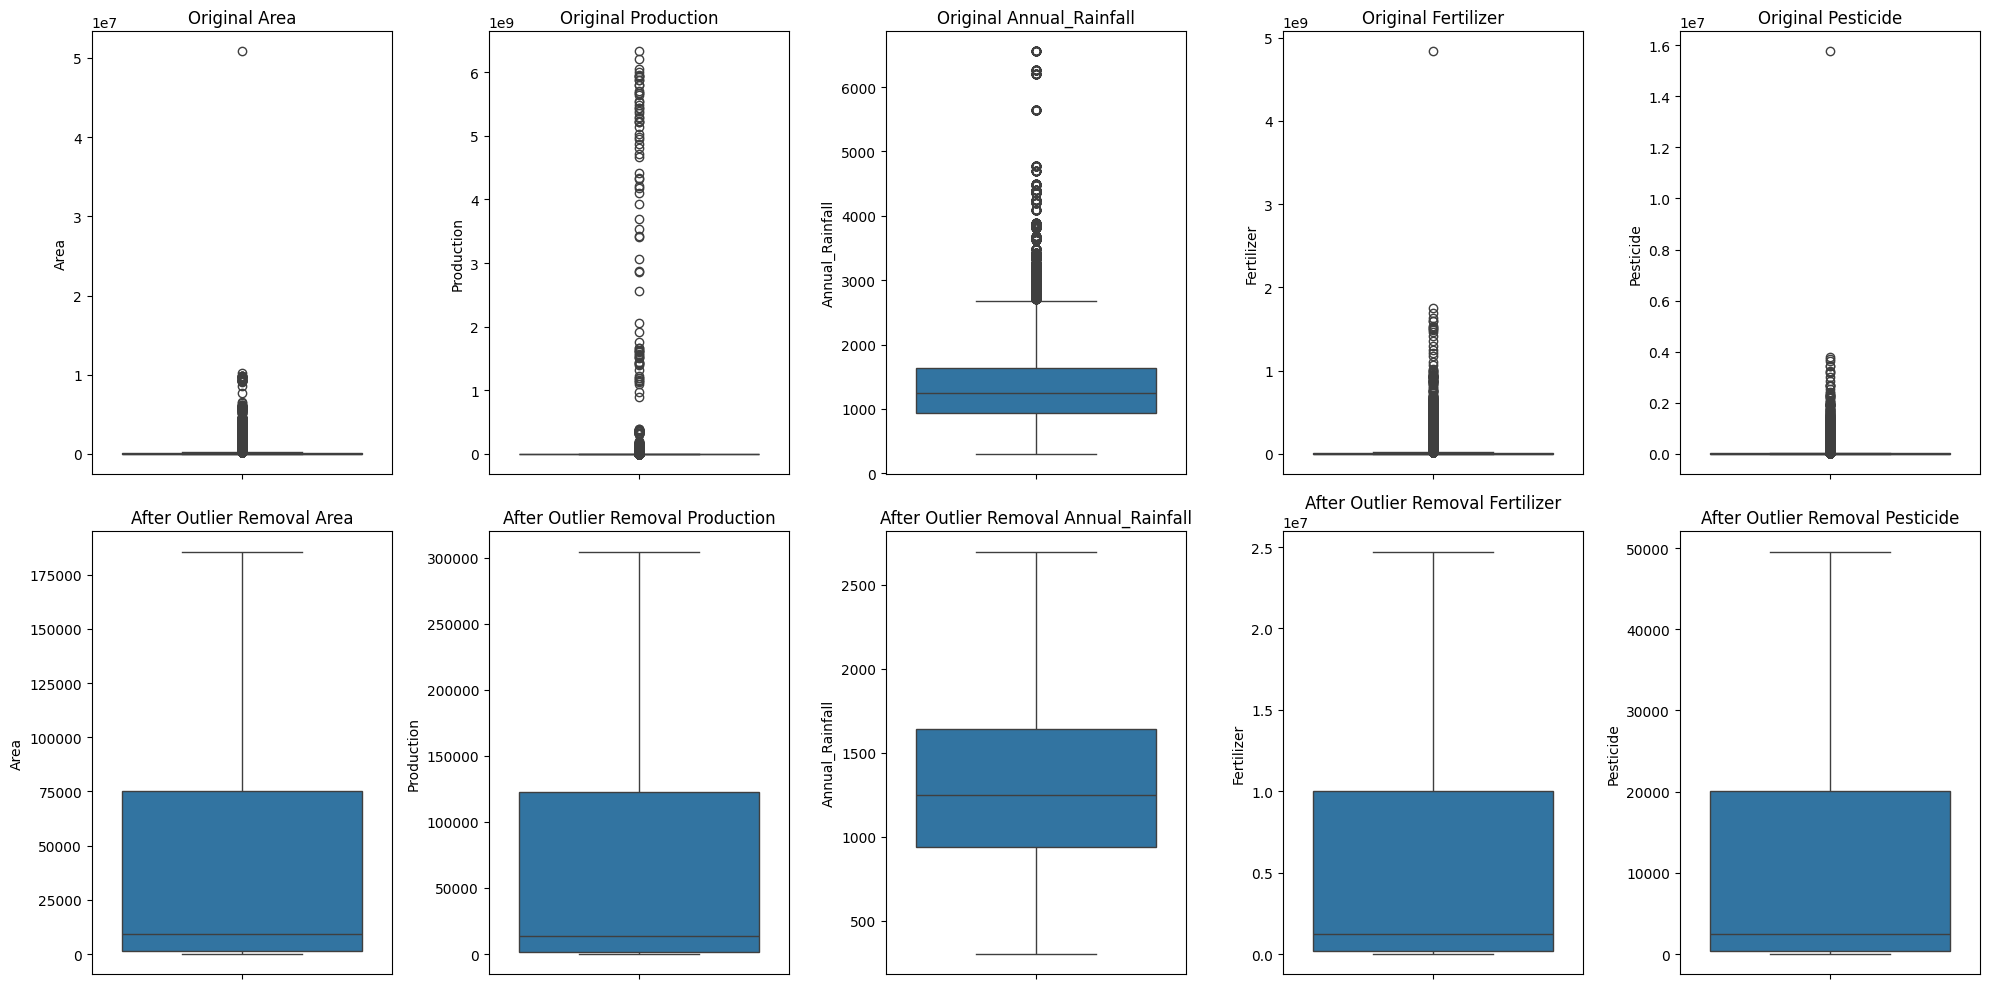

In [ ]:
# List of variables to process
variables = ['Area', 'Production', 'Annual_Rainfall', 'Fertilizer', 'Pesticide']

# Making a copy of the original data
new_df = df.copy()

# Defining a Function to calculate IQR and cap the outliers
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Caping the outliers
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

# Applying outlier removal to the selected variables
for col in variables:
    remove_outliers_iqr(new_df, col)

# Plotting boxplots before and after removing outliers
plt.figure(figsize=(20, 10))

# Highlighting the Boxplots before outlier removal
for i, col in enumerate(variables, 1):
    plt.subplot(2, len(variables), i)
    sns.boxplot(data=df, y=col)
    plt.title(f'Original {col}')

# Highlighting Boxplots after outlier removal
for i, col in enumerate(variables, 1):
    plt.subplot(2, len(variables), i + len(variables))
    sns.boxplot(data=new_df, y=col)
    plt.title(f'After Outlier Removal {col}')

plt.tight_layout()
plt.show()


In [ ]:
df.describe()

,Crop_Year,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
count,19689.000000,1.968900e+04,1.968900e+04,19689.000000,1.968900e+04,1.968900e+04,19689.000000
mean,2009.127584,1.799266e+05,1.643594e+07,1437.755177,2.410331e+07,4.884835e+04,79.954009
std,6.498099,7.328287e+05,2.630568e+08,816.909589,9.494600e+07,2.132874e+05,878.306193
min,1997.000000,5.000000e-01,0.000000e+00,301.300000,5.417000e+01,9.000000e-02,0.000000
25%,2004.000000,1.390000e+03,1.393000e+03,940.700000,1.880146e+05,3.567000e+02,0.600000
50%,2010.000000,9.317000e+03,1.380400e+04,1247.600000,1.234957e+06,2.421900e+03,1.030000
75%,2015.000000,7.511200e+04,1.227180e+05,1643.700000,1.000385e+07,2.004170e+04,2.388889
max,2020.000000,5.080810e+07,6.326000e+09,6552.700000,4.835407e+09,1.575051e+07,21105.000000


In [ ]:
new_df.describe()

,Crop_Year,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
count,19689.000000,19689.000000,19689.000000,19689.000000,1.968900e+04,19689.000000,19689.000000
mean,2009.127584,49091.865530,80716.405988,1371.231397,6.528931e+06,13013.902888,79.954009
std,6.498099,68864.272117,115591.715658,614.694947,9.148706e+06,18328.408492,878.306193
min,1997.000000,0.500000,0.000000,301.300000,5.417000e+01,0.090000,0.000000
25%,2004.000000,1390.000000,1393.000000,940.700000,1.880146e+05,356.700000,0.600000
50%,2010.000000,9317.000000,13804.000000,1247.600000,1.234957e+06,2421.900000,1.030000
75%,2015.000000,75112.000000,122718.000000,1643.700000,1.000385e+07,20041.700000,2.388889
max,2020.000000,185695.000000,304705.500000,2698.200000,2.472760e+07,49569.200000,21105.000000


In [ ]:
numeric_columns = new_df.select_dtypes(include='number')
df_year = new_df[new_df['Crop_Year']!=2020]

annual_data = df_year.groupby('Crop_Year').sum()
annual_data.head()

,Crop,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
Crop_Year,,,,,,,,,
1997,ArecanutArhar/TurCastor seedCoconut Cotton(lin...,Whole Year Kharif Kharif Whole Year Kh...,AssamAssamAssamAssamAssamAssamAssamAssamAssamA...,29992225.00,44164271.5,6.144444e+05,3.524786e+09,8.436849e+06,26187.756592
1998,ArecanutBajraBlack pepperCorianderCotton(lint)...,Kharif Kharif Kharif Kharif Su...,PuducherryPuducherryPuducherryPuducherryPuduch...,38558100.00,59404490.5,1.010523e+06,4.579527e+09,1.061340e+07,36136.246483
1999,ArecanutArhar/TurBananaCastor seedCoconut Cott...,Whole Year Kharif Whole Year Kharif Wh...,AssamAssamAssamAssamAssamAssamAssamAssamAssamA...,41098149.00,62983916.0,9.366956e+05,5.000282e+09,1.102003e+07,50013.419395
2000,ArecanutArhar/TurArhar/TurBajraBajraBananaCash...,Whole Year Kharif Rabi Kharif Ra...,Andhra PradeshAndhra PradeshAndhra PradeshAndh...,42994278.00,64656315.0,1.009690e+06,5.030482e+09,1.135075e+07,58342.279827
2001,ArecanutArhar/TurArhar/TurBajraBajraBananaCash...,Whole Year Kharif Rabi Kharif Ra...,Andhra PradeshAndhra PradeshAndhra PradeshAndh...,40997562.67,62822973.5,1.015917e+06,4.904745e+09,1.082620e+07,56581.195447


##  **Exploraroty Data Analysis**

## **Yearwise Analysis**

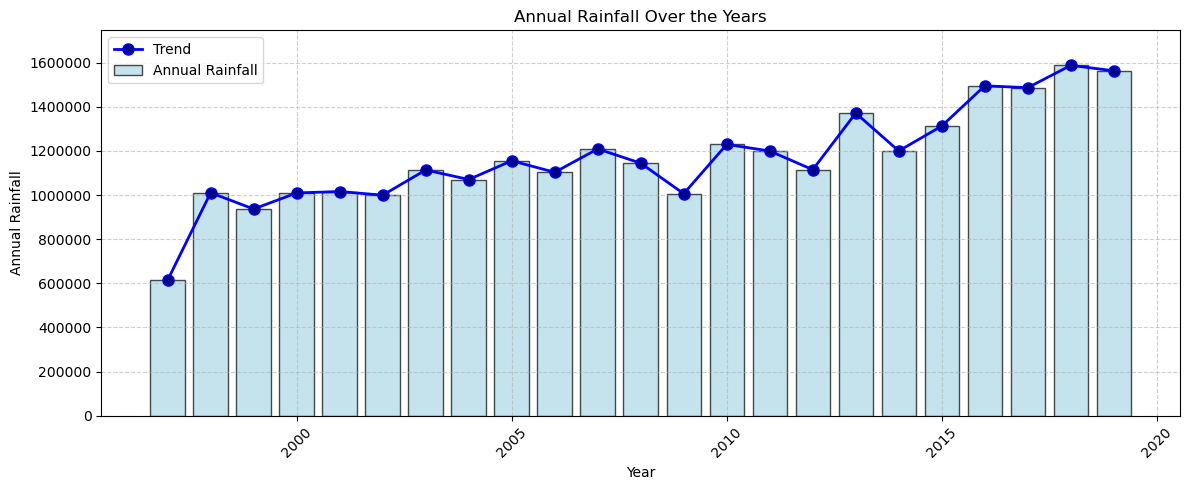

In [ ]:
# Plotting graph of Annual Rainfall over the Years
fig, ax = plt.subplots(figsize=(12, 5))

x = annual_data.index
y = annual_data['Annual_Rainfall']

ax.bar(x, y, color='lightblue', edgecolor='black', alpha=0.7, label='Annual Rainfall')

ax.plot(x, y, color='blue', marker='o', markersize=8, markerfacecolor='darkblue', linewidth=2, label='Trend')

ax.set(
    xlabel="Year",
    ylabel="Annual Rainfall",
    title="Annual Rainfall Over the Years"
)

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')

plt.xticks(rotation=45)

ax.grid(True, linestyle='--', alpha=0.6)

ax.set_ylim([0, max(y) * 1.1])

ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Observation from graph

This graphs shows that there is a gradual increase in rainfall, reaching a peak around 2019-2020. Overall, the trend indicates a slight increase in annual rainfall over the years.


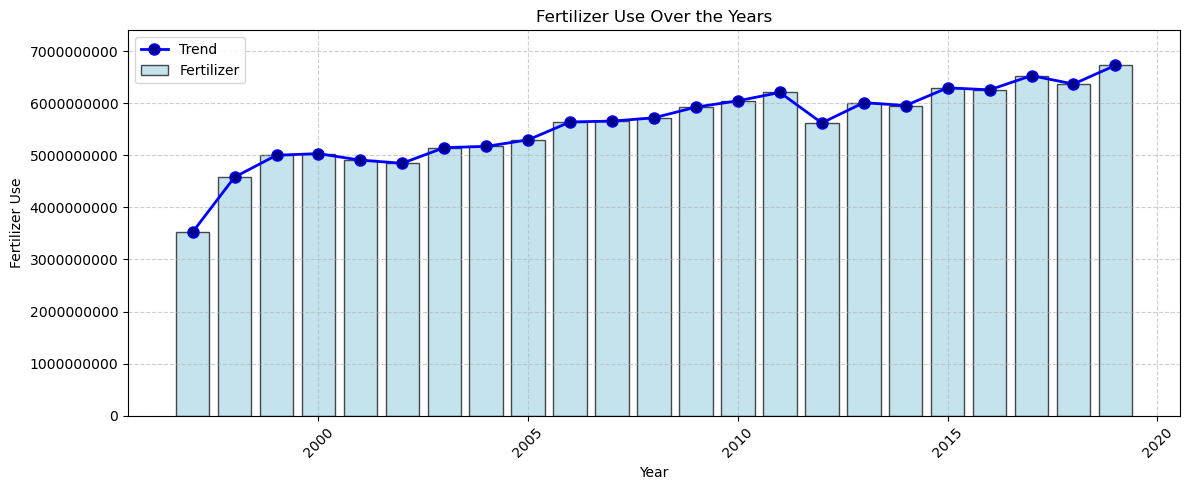

In [ ]:
# Plotting graph of use of Fertilizer over the Years
fig, ax = plt.subplots(figsize=(12, 5))

x = annual_data.index
y = annual_data['Fertilizer']

ax.bar(x, y, color='lightblue', edgecolor='black', alpha=0.7, label='Fertilizer')

ax.plot(x, y, color='blue', marker='o', markersize=8, markerfacecolor='darkblue', linewidth=2, label='Trend')

ax.set(
    xlabel="Year",
    ylabel="Fertilizer Use",
    title="Fertilizer Use Over the Years"
)

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')

plt.xticks(rotation=45)

ax.grid(True, linestyle='--', alpha=0.6)

ax.set_ylim([0, max(y) * 1.1])

ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Observation from graph
This graphs shows a high increase in the usage of fertilizer over the years.It indicates efforts to boost crop yields and improve soil productivity. This increase could be due to rising agricultural demands and advancements in farming techniques.

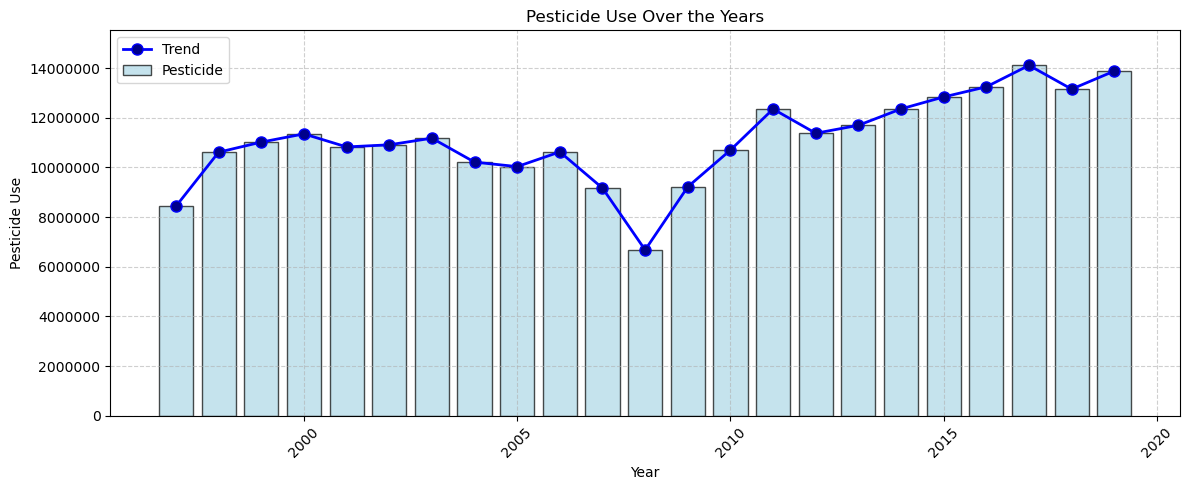

In [ ]:
# Plotting graph of use of Pesticides over the Years
fig, ax = plt.subplots(figsize=(12, 5))

x = annual_data.index
y = annual_data['Pesticide']

ax.bar(x, y, color='lightblue', edgecolor='black', alpha=0.7, label='Pesticide')

ax.plot(x, y, color='blue', marker='o', markersize=8, markerfacecolor='darkblue', linewidth=2, label='Trend')

ax.set(
    xlabel="Year",
    ylabel="Pesticide Use",
    title="Pesticide Use Over the Years"
)

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')

plt.xticks(rotation=45)

ax.grid(True, linestyle='--', alpha=0.6)

ax.set_ylim([0, max(y) * 1.1])

ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Observation from graph

 It shows a steady increase from 2008 onwards. This rise continues with some fluctuations, peaking in 2018 and 2020. Overall, there is a growing reliance on pesticides in recent years, reflecting changes in agricultural practices or pest management needs.


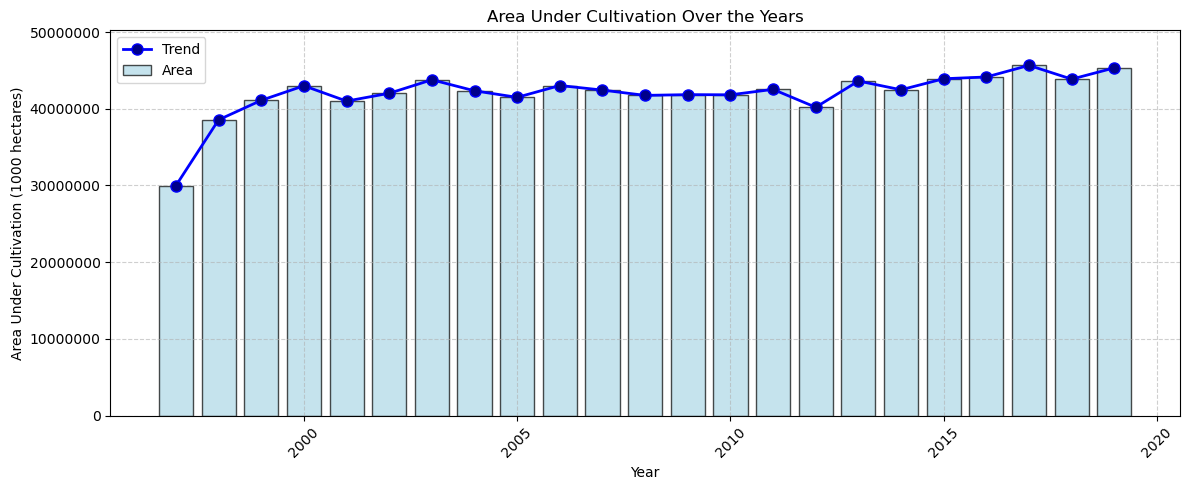

In [ ]:
# Plotting graph of Area under cultivation over the Years
fig, ax = plt.subplots(figsize=(12, 5))

x = annual_data.index
y = annual_data['Area']

ax.bar(x, y, color='lightblue', edgecolor='black', alpha=0.7, label='Area')

ax.plot(x, y, color='blue', marker='o', markersize=8, markerfacecolor='darkblue', linewidth=2, label='Trend')

ax.set(
    xlabel="Year",
    ylabel="Area Under Cultivation (1000 hectares)",
    title="Area Under Cultivation Over the Years"
)

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')

plt.xticks(rotation=45)

ax.grid(True, linestyle='--', alpha=0.6)

ax.set_ylim([0, max(y) * 1.1])

ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Observation from graph

The area used for farming has grown a lot. This might have happened because more fertilizers and better irrigation are being used, turning land that was not previously farmed into productive fields.

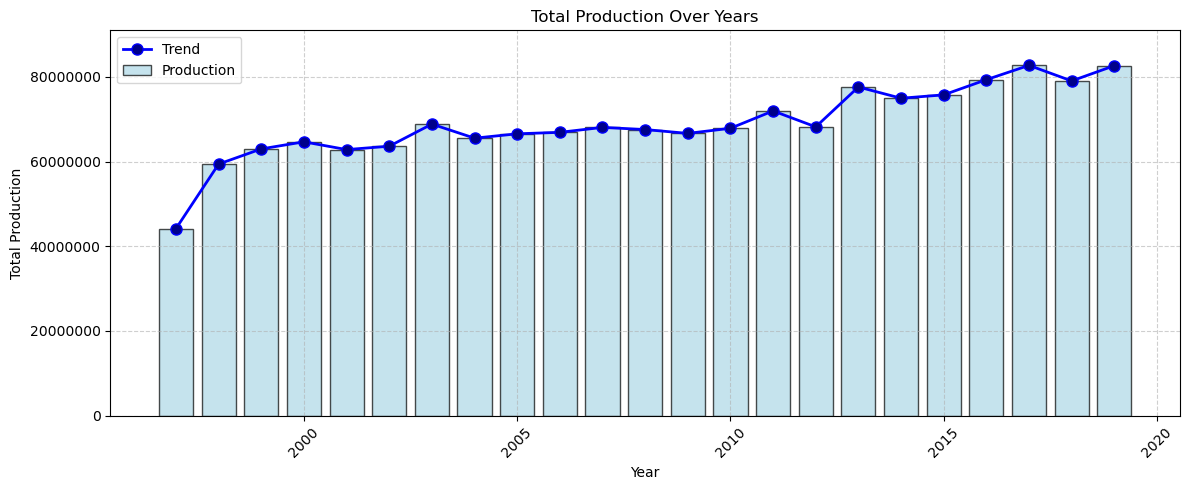

In [ ]:
# Plotting graph of Total Production over the Years
fig, ax = plt.subplots(figsize=(12, 5))
x = annual_data.index
y = annual_data['Production']

ax.bar(x, y, color='lightblue', edgecolor='black', alpha=0.7, label='Production')

ax.plot(x, y, color='blue', marker='o', markersize=8, markerfacecolor='darkblue', linewidth=2, label='Trend')

ax.set(
    xlabel="Year",
    ylabel="Total Production",
    title="Total Production Over Years"
)

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')

plt.xticks(rotation=45)

ax.grid(True, linestyle='--', alpha=0.6)

ax.set_ylim([0, max(y) * 1.1])

ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Observation from graph
The graph shows an overall increase in total production from 1998 to 2020, with a steady rise until 2008, a sharp decline and spike around 2009-2011, and fluctuations stabilizing in the later years. Production levels remain relatively high after 2015, indicating sustained growth despite earlier volatility.

## **Seasonwise Analysis**

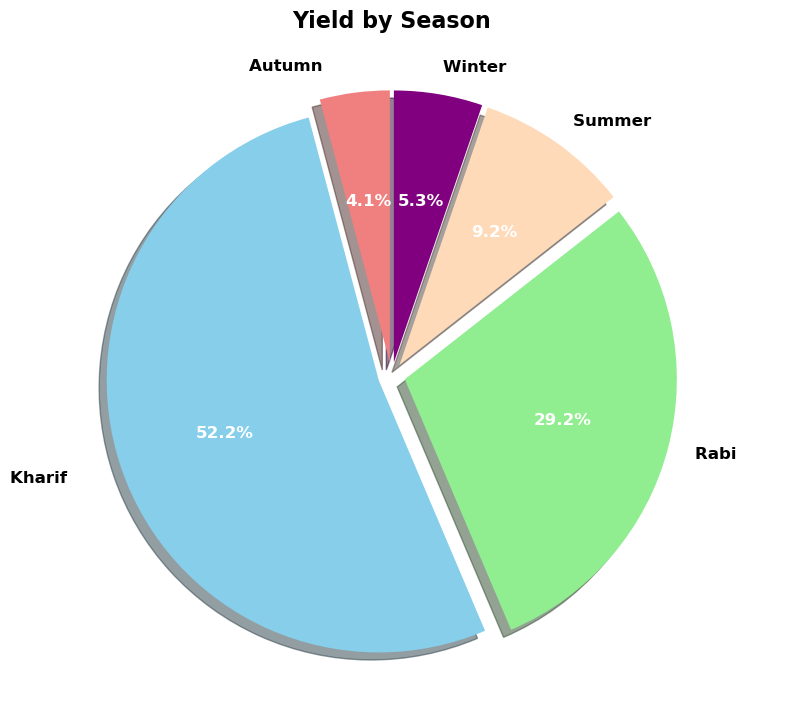

In [ ]:
# Plotting pie chart of Yield by Season
df_Seas = new_df[new_df['Season'] != 'Whole Year ']
df_season = df_Seas.groupby('Season').sum()

colors = ['lightcoral', 'skyblue', 'lightgreen', 'peachpuff', 'purple']

explode = [0.05] * len(df_season)

fig, ax = plt.subplots(figsize=(8, 8))

wedges, texts, autotexts = ax.pie(df_season['Yield'],
                                  labels=df_season.index,
                                  colors=colors,
                                  autopct='%1.1f%%',
                                  startangle=90,
                                  explode=explode,
                                  shadow=True)

ax.set_aspect('equal')

ax.set_title('Yield by Season', fontsize=16, fontweight='bold')

for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

C:\Users\aruki\AppData\Local\Temp\ipykernel_24552\4001998552.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_season_sorted.index, rotation=45, ha='right', fontsize=10)


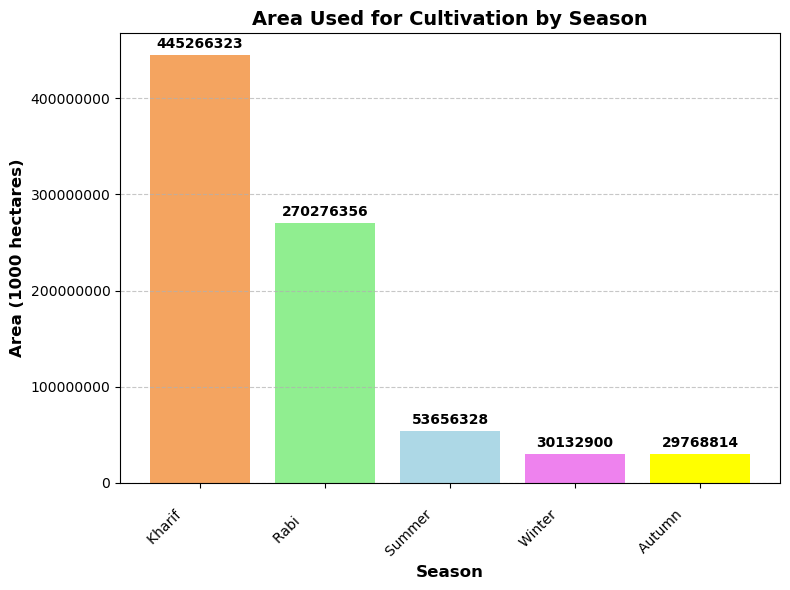

In [ ]:
df_season_sorted = df_season.sort_values(by='Area', ascending=False)

colors = ['sandybrown', 'lightgreen', 'lightblue', 'violet', 'yellow']

fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(df_season_sorted.index, df_season_sorted['Area'], color=colors[:len(df_season_sorted)])

ax.set_xlabel('Season', fontsize=12, fontweight='bold')
ax.set_ylabel('Area (1000 hectares)', fontsize=12, fontweight='bold')
ax.set_title('Area Used for Cultivation by Season', fontsize=14, fontweight='bold')

ax.set_xticklabels(df_season_sorted.index, rotation=45, ha='right', fontsize=10)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')

ax.grid(True, axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.0f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset above the bar
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

fig.tight_layout()

plt.show();

# **Observations from graph**

* The area under cultivation is the largest during the Kharif season, followed by the Rabi season.
* Crops grown in autumn and winter cover relatively smaller areas.
* In India, the yield is the highest during the Kharif season


## **Cropwise Analysis**

In [ ]:
# filtering where yield is more than zero
df_ynz = new_df[new_df['Yield']>0]
df_crop = df_ynz.groupby('Crop').sum()

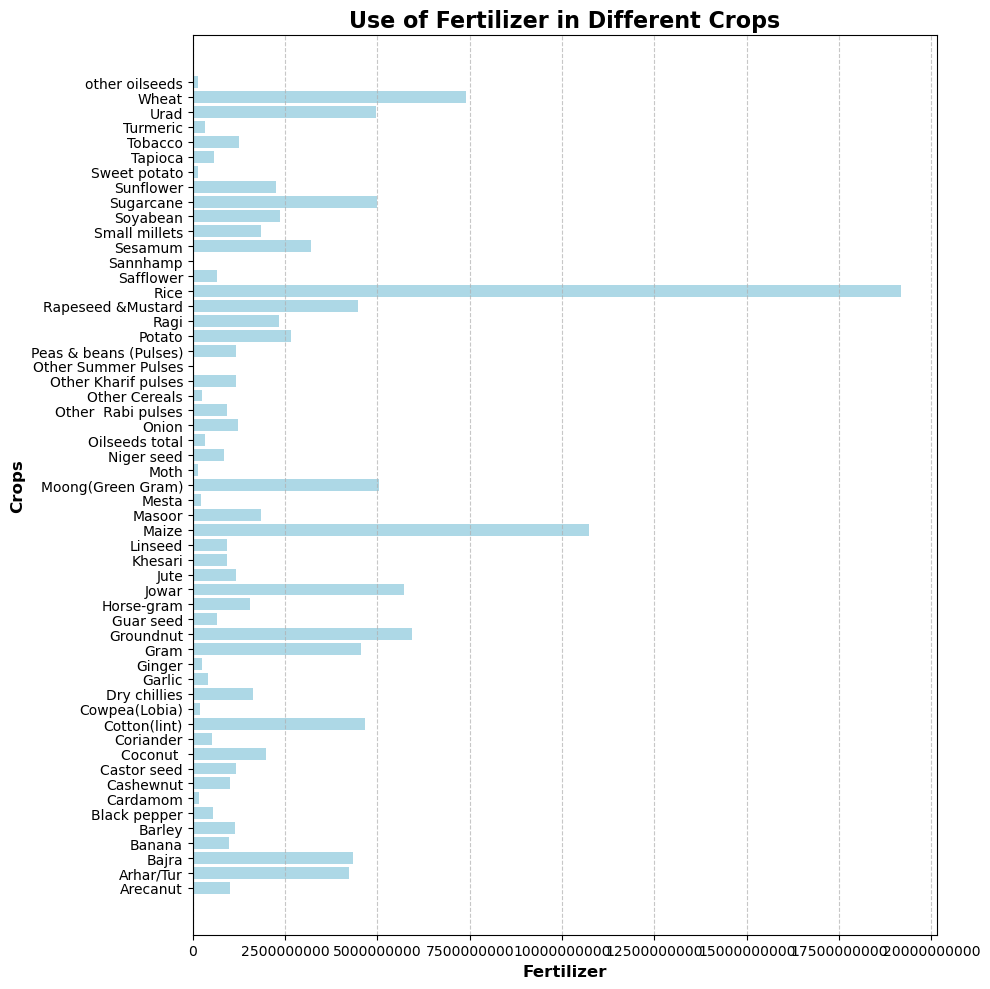

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

bars = ax.barh(df_crop.index, df_crop['Fertilizer'], color='lightblue', label='Fertilizer')

ax.set_title('Use of Fertilizer in Different Crops', fontsize=16, fontweight='bold')
ax.set_xlabel('Fertilizer', fontsize=12, fontweight='bold')
ax.set_ylabel('Crops', fontsize=12, fontweight='bold')
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='x')

ax.grid(True, axis='x', linestyle='--', alpha=0.7)

fig.tight_layout()

plt.show()

C:\Users\aruki\AppData\Local\Temp\ipykernel_24552\3040090651.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_5_crops.index, rotation=-30, ha='left', fontsize=10)


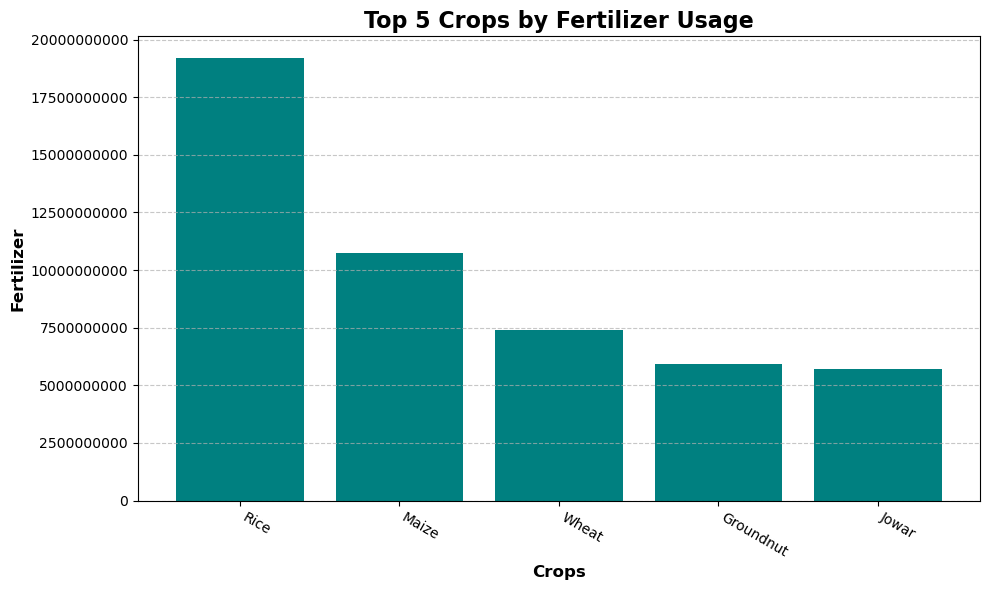

In [ ]:
sorted_df_crop = df_crop.sort_values(by='Fertilizer', ascending=False)

top_5_crops = sorted_df_crop.head(5)

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(top_5_crops.index, top_5_crops['Fertilizer'], color='teal', label='Fertilizer')

ax.set_title('Top 5 Crops by Fertilizer Usage', fontsize=16, fontweight='bold')
ax.set_xlabel('Crops', fontsize=12, fontweight='bold')
ax.set_ylabel('Fertilizer', fontsize=12, fontweight='bold')

ax.set_xticklabels(top_5_crops.index, rotation=-30, ha='left', fontsize=10)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')

ax.grid(True, axis='y', linestyle='--', alpha=0.7)

fig.tight_layout()

plt.show()

C:\Users\aruki\AppData\Local\Temp\ipykernel_24552\2039932536.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bottom_5_crops.index, rotation=-30, ha='left', fontsize=10)


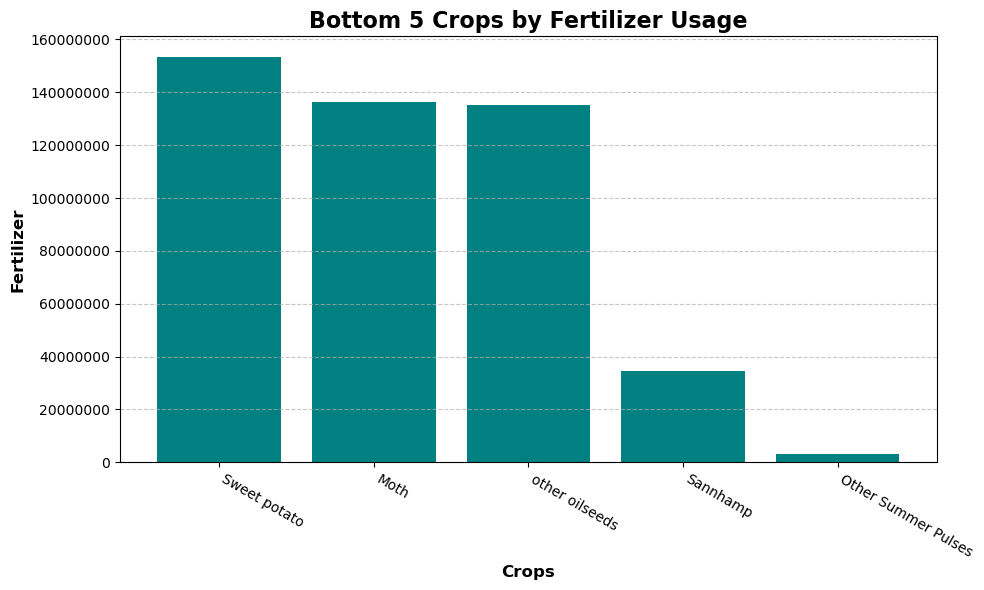

In [ ]:
import matplotlib.pyplot as plt

sorted_df_crop = df_crop.sort_values(by='Fertilizer', ascending=False)

bottom_5_crops = sorted_df_crop.tail(5)

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(bottom_5_crops.index, bottom_5_crops['Fertilizer'], color='teal', label='Fertilizer')

ax.set_title('Bottom 5 Crops by Fertilizer Usage', fontsize=16, fontweight='bold')
ax.set_xlabel('Crops', fontsize=12, fontweight='bold')
ax.set_ylabel('Fertilizer', fontsize=12, fontweight='bold')

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')

ax.set_xticklabels(bottom_5_crops.index, rotation=-30, ha='left', fontsize=10)

ax.grid(True, axis='y', linestyle='--', alpha=0.7)

fig.tight_layout()

plt.show()

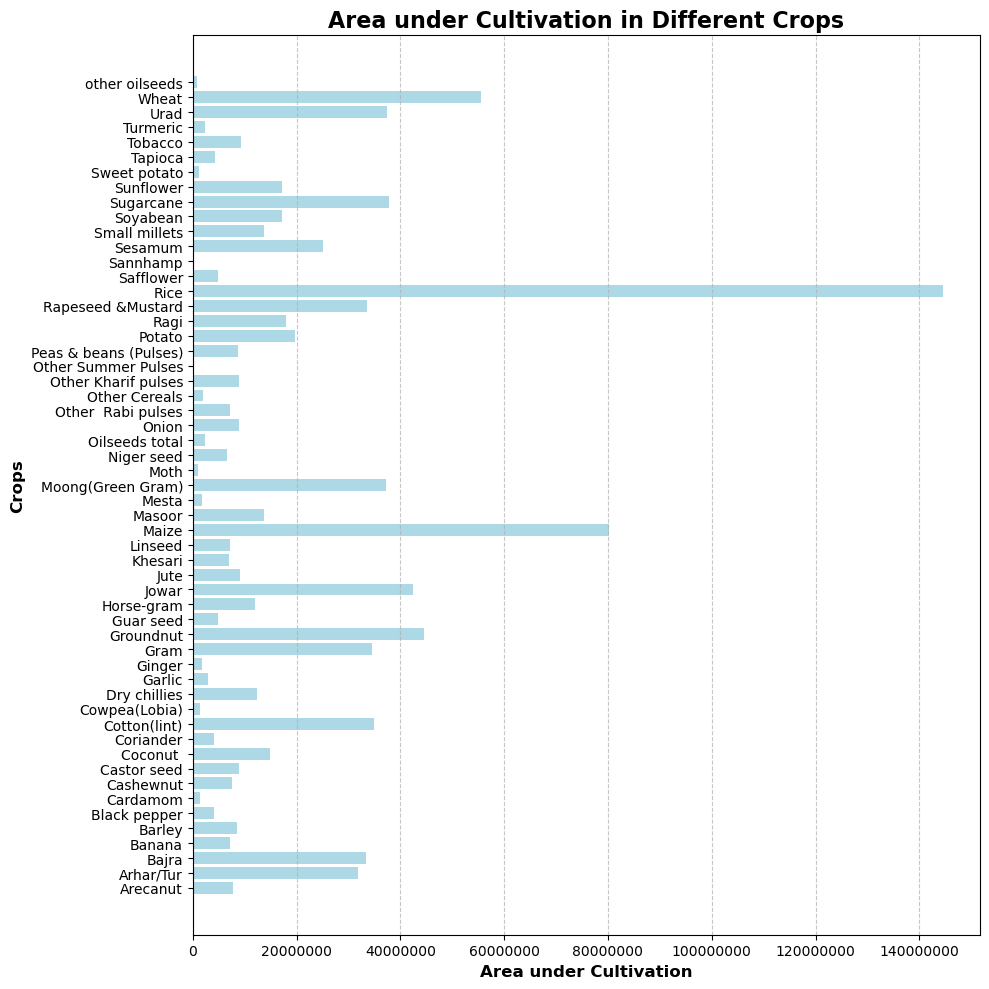

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

bars = ax.barh(df_crop.index, df_crop['Area'], color='lightblue', label='Area')

ax.set_title('Area under Cultivation in Different Crops', fontsize=16, fontweight='bold')
ax.set_xlabel('Area under Cultivation', fontsize=12, fontweight='bold')
ax.set_ylabel('Crops', fontsize=12, fontweight='bold')

ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='x')

ax.grid(True, axis='x', linestyle='--', alpha=0.7)

fig.tight_layout()

plt.show()

C:\Users\aruki\AppData\Local\Temp\ipykernel_24552\2642015194.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_5_crops.index, rotation=-30, ha='left', fontsize=10)


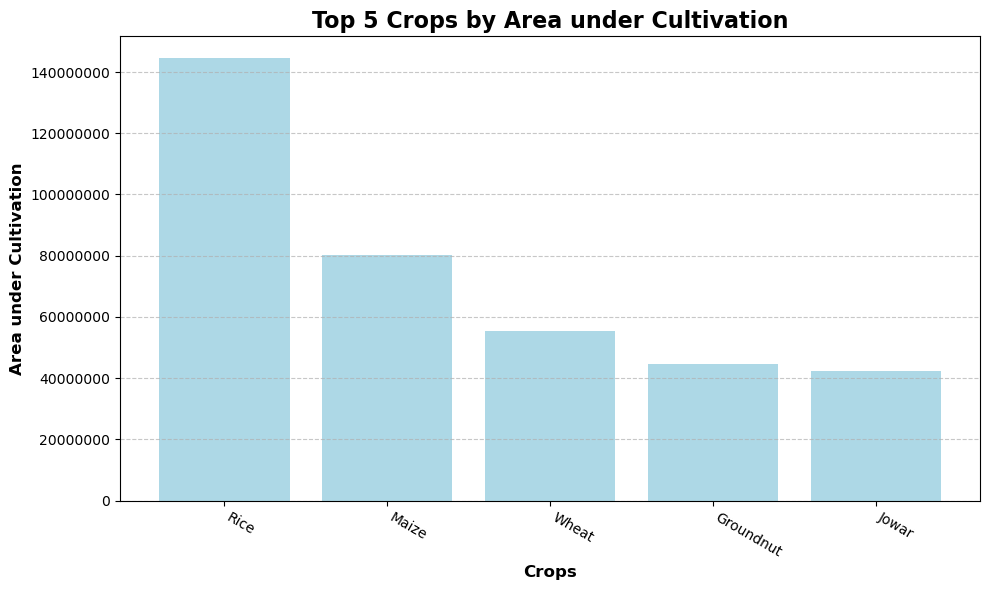

In [ ]:
sorted_df_crop = df_crop.sort_values(by='Area', ascending=False)

top_5_crops = sorted_df_crop.head(5)

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(top_5_crops.index, top_5_crops['Area'], color='lightblue', label='Area')

ax.set_title('Top 5 Crops by Area under Cultivation', fontsize=16, fontweight='bold')
ax.set_xlabel('Crops', fontsize=12, fontweight='bold')
ax.set_ylabel('Area under Cultivation', fontsize=12, fontweight='bold')

ax.set_xticklabels(top_5_crops.index, rotation=-30, ha='left', fontsize=10)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')

ax.grid(True, axis='y', linestyle='--', alpha=0.7)

fig.tight_layout()

plt.show()

C:\Users\aruki\AppData\Local\Temp\ipykernel_24552\2505107300.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bottom_5_crops.index, rotation=-30, ha='left', fontsize=10)


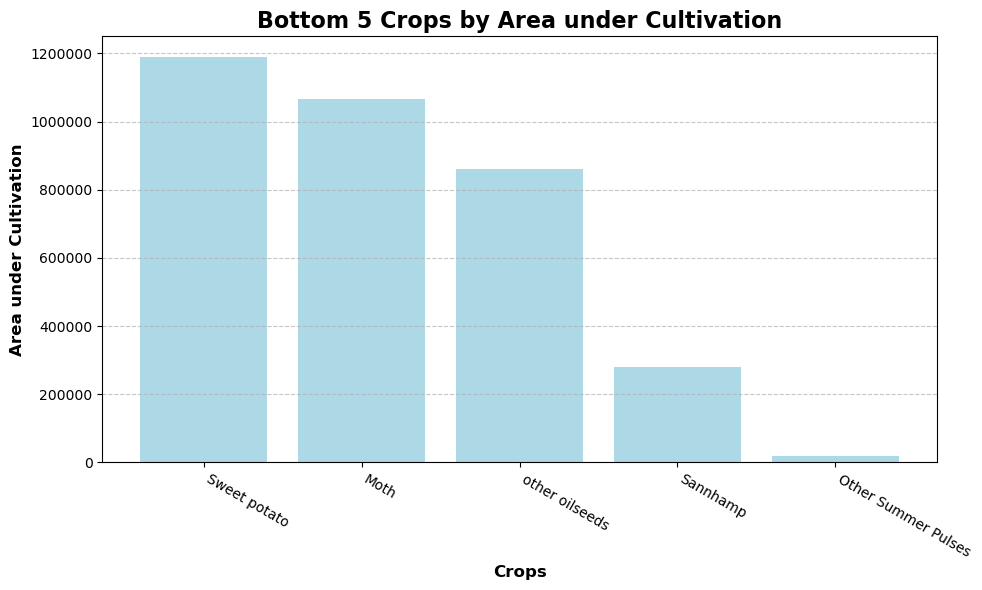

In [ ]:
sorted_df_crop = df_crop.sort_values(by='Area', ascending=False)

bottom_5_crops = sorted_df_crop.tail(5)

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(bottom_5_crops.index, bottom_5_crops['Area'], color='lightblue', label='Area')

ax.set_title('Bottom 5 Crops by Area under Cultivation', fontsize=16, fontweight='bold')
ax.set_xlabel('Crops', fontsize=12, fontweight='bold')
ax.set_ylabel('Area under Cultivation', fontsize=12, fontweight='bold')

ax.set_xticklabels(bottom_5_crops.index, rotation=-30, ha='left', fontsize=10)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')

ax.grid(True, axis='y', linestyle='--', alpha=0.7)

fig.tight_layout()

plt.show()

# **Observations from graph**

* Rice,Wheat and cotton have the highest fertilizer usage.
* Crops like Cardamom,other oilseeds,Sweet potato and other summer pulses have the lowest fertilizer usage.

## **Statewise Analysis**

C:\Users\aruki\AppData\Local\Temp\ipykernel_24552\1409372498.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(state_rainfall.index, rotation=90, ha='center', fontsize=10)


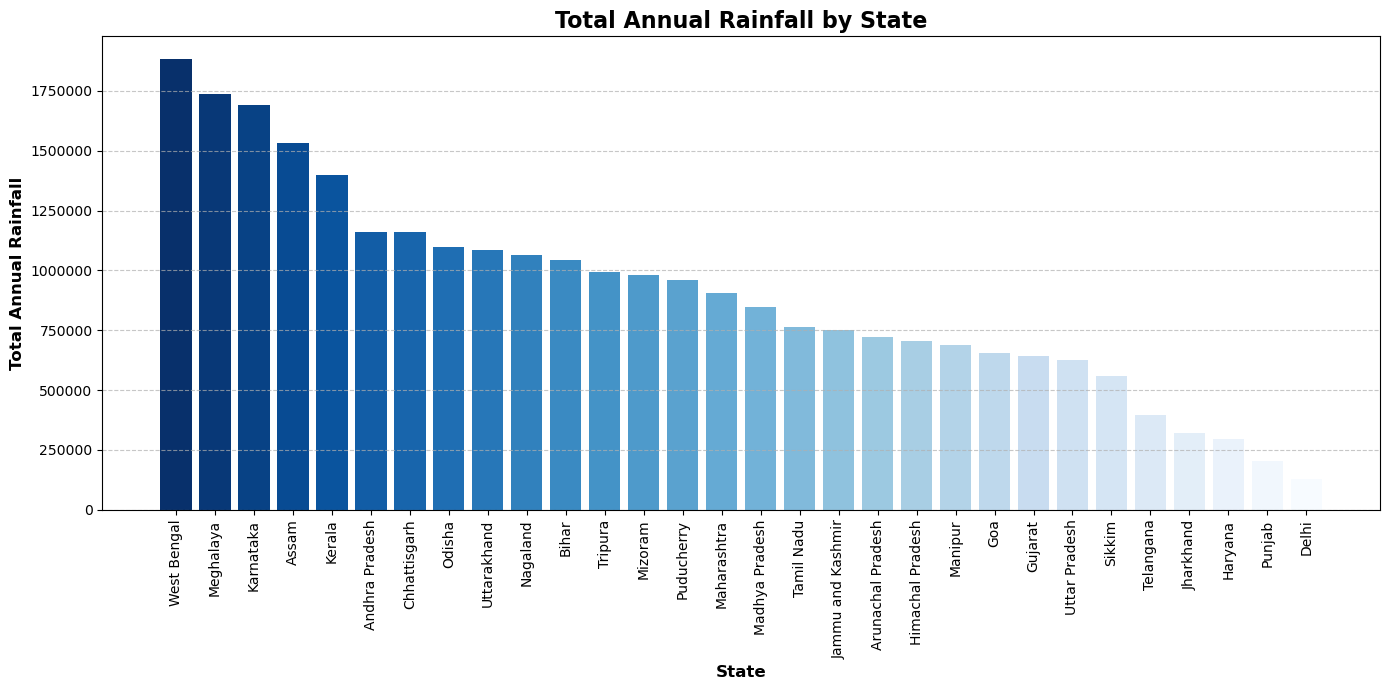

In [ ]:
state_rainfall = new_df.groupby('State')['Annual_Rainfall'].sum().sort_values(ascending=False)

num_states = len(state_rainfall)

colormap = plt.cm.Blues_r
colors = colormap(np.linspace(0, 1, num_states))

fig, ax = plt.subplots(figsize=(14, 7))

bars = ax.bar(state_rainfall.index, state_rainfall, color=colors)

ax.set_xlabel('State', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Annual Rainfall', fontsize=12, fontweight='bold')
ax.set_title('Total Annual Rainfall by State', fontsize=16, fontweight='bold')

ax.grid(True, axis='y', linestyle='--', alpha=0.7)

ax.set_xticklabels(state_rainfall.index, rotation=90, ha='center', fontsize=10)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')

fig.tight_layout()

plt.show()

C:\Users\aruki\AppData\Local\Temp\ipykernel_24552\4034110794.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(state_area.index, rotation=90, ha='center', fontsize=10)


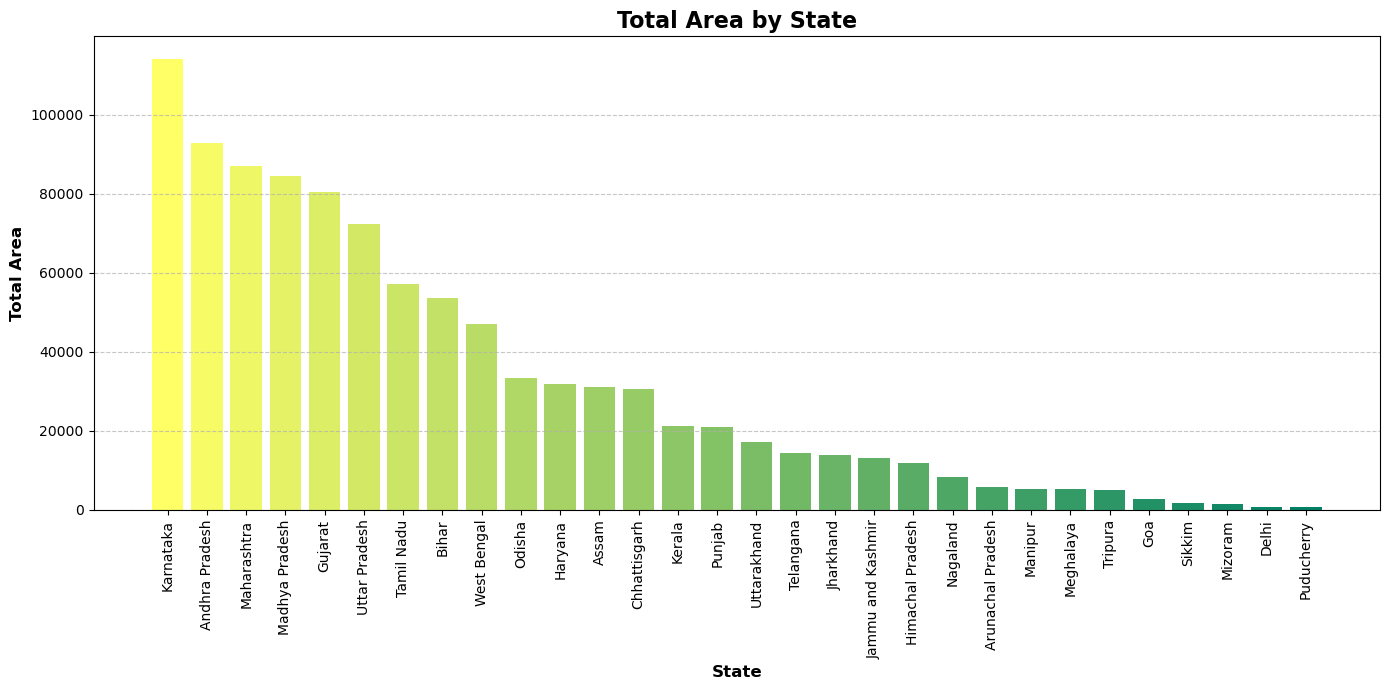

In [ ]:
state_area = new_df.groupby('State')['Area'].sum().sort_values(ascending=False)

num_states = len(state_area)

colormap = plt.cm.summer_r
colors = colormap(np.linspace(0, 1, num_states))

fig, ax = plt.subplots(figsize=(14, 7))

bars = ax.bar(state_area.index, state_area/1000, color=colors)

ax.set_xlabel('State', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Area', fontsize=12, fontweight='bold')
ax.set_title('Total Area by State', fontsize=16, fontweight='bold')

ax.grid(True, axis='y', linestyle='--', alpha=0.7)

ax.set_xticklabels(state_area.index, rotation=90, ha='center', fontsize=10)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')

fig.tight_layout()

plt.show()

C:\Users\aruki\AppData\Local\Temp\ipykernel_24552\3836156963.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(state_fertilizer.index, rotation=90, ha='center', fontsize=10)


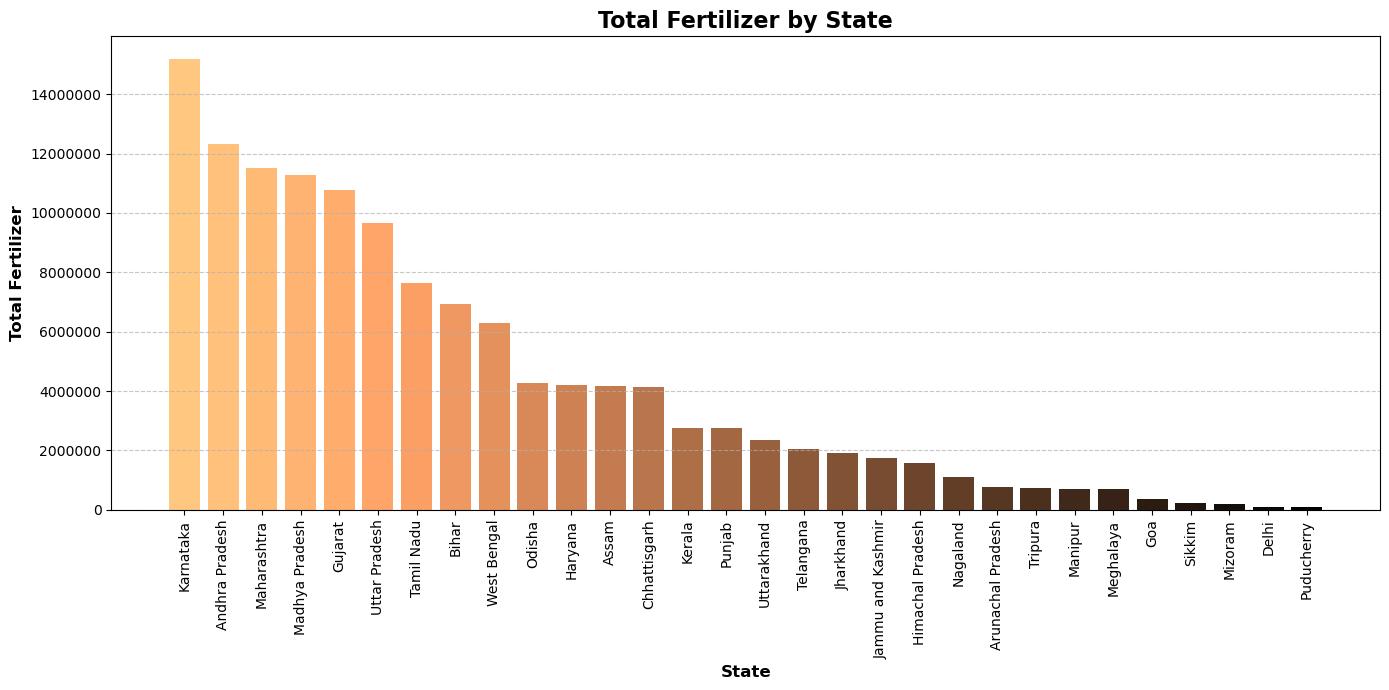

In [ ]:
state_fertilizer = new_df.groupby('State')['Fertilizer'].sum().sort_values(ascending=False)

num_states = len(state_fertilizer)

colormap = plt.cm.copper_r
colors = colormap(np.linspace(0, 1, num_states))

fig, ax = plt.subplots(figsize=(14, 7))

bars = ax.bar(state_fertilizer.index, state_fertilizer/1000, color=colors)

ax.set_xlabel('State', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Fertilizer', fontsize=12, fontweight='bold')
ax.set_title('Total Fertilizer by State', fontsize=16, fontweight='bold')

ax.grid(True, axis='y', linestyle='--', alpha=0.7)

ax.set_xticklabels(state_fertilizer.index, rotation=90, ha='center', fontsize=10)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')

fig.tight_layout()

plt.show()

C:\Users\aruki\AppData\Local\Temp\ipykernel_24552\3168058431.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(state_pest.index, rotation=90, ha='center', fontsize=10)


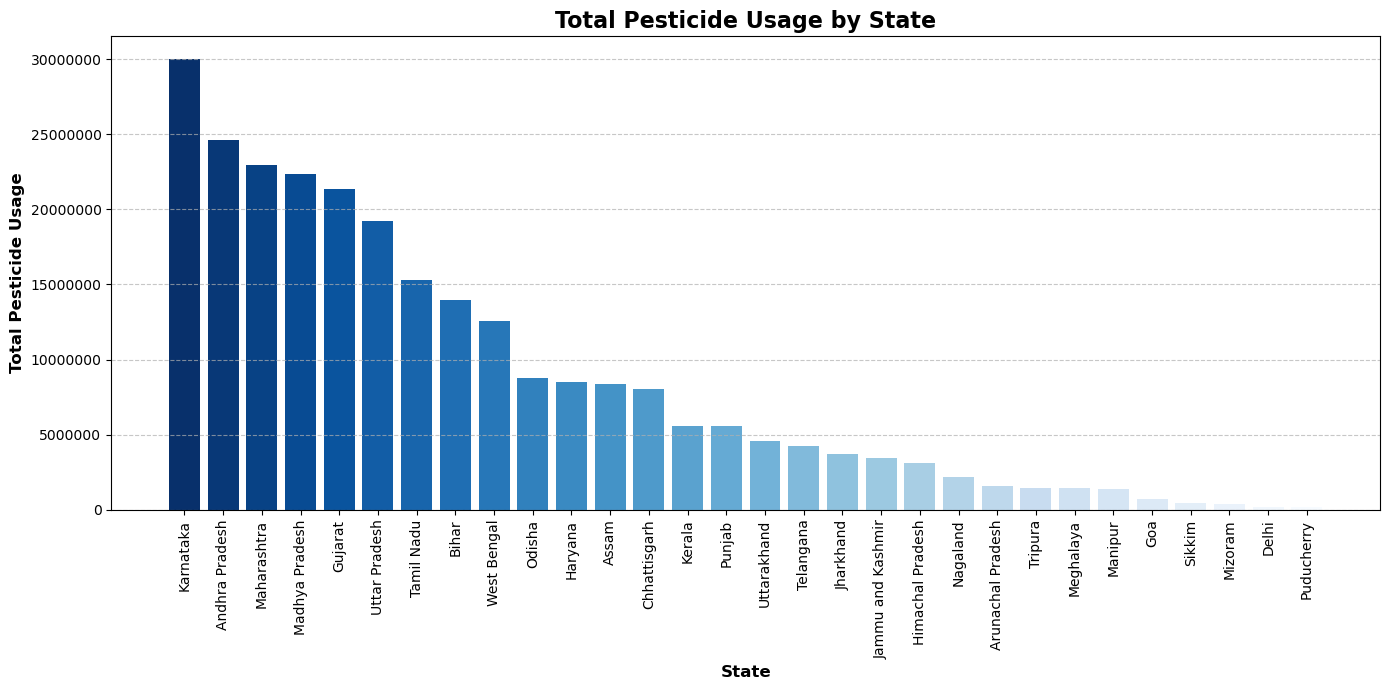

In [ ]:
state_pest = new_df.groupby('State')['Pesticide'].sum().sort_values(ascending=False)

num_states = len(state_pest)

colormap = plt.cm.Blues_r
colors = colormap(np.linspace(0, 1, num_states))

fig, ax = plt.subplots(figsize=(14, 7))

bars = ax.bar(state_pest.index, state_pest, color=colors)

ax.set_xlabel('State', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Pesticide Usage', fontsize=12, fontweight='bold')
ax.set_title('Total Pesticide Usage by State', fontsize=16, fontweight='bold')

ax.grid(True, axis='y', linestyle='--', alpha=0.7)

ax.set_xticklabels(state_pest.index, rotation=90, ha='center', fontsize=10)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')

fig.tight_layout()

plt.show()

# **Observations from graphs**

*   
Karnataka experiences the highest annual rainfall; however, it does not have the highest yield.
* In contrast, West Bengal leads in yield.
*  States like Uttar Pradesh, Haryana, and Maharashtra have high area under cultivation.
* States like Uttar Pradesh, Haryana, and Maharashtra are applying a large amount of fertilizer and high amout of pesticides, yet their yields remain low, likely due to insufficient annual rainfall.

## Area vs Yield Correlation plot

In [ ]:
#Filtering data for plotting correaltions
crop_column = 'Crop'

# Filtering the unique crop names
unique_crops = new_df[crop_column].unique()

# Creating a dictionary to hold the DataFrames for each crop
crop_dfs = {}

# Iterating through each unique crop and create a separate DataFrame
for crop in unique_crops:
    crop_dfs[crop] = new_df[new_df[crop_column] == crop]

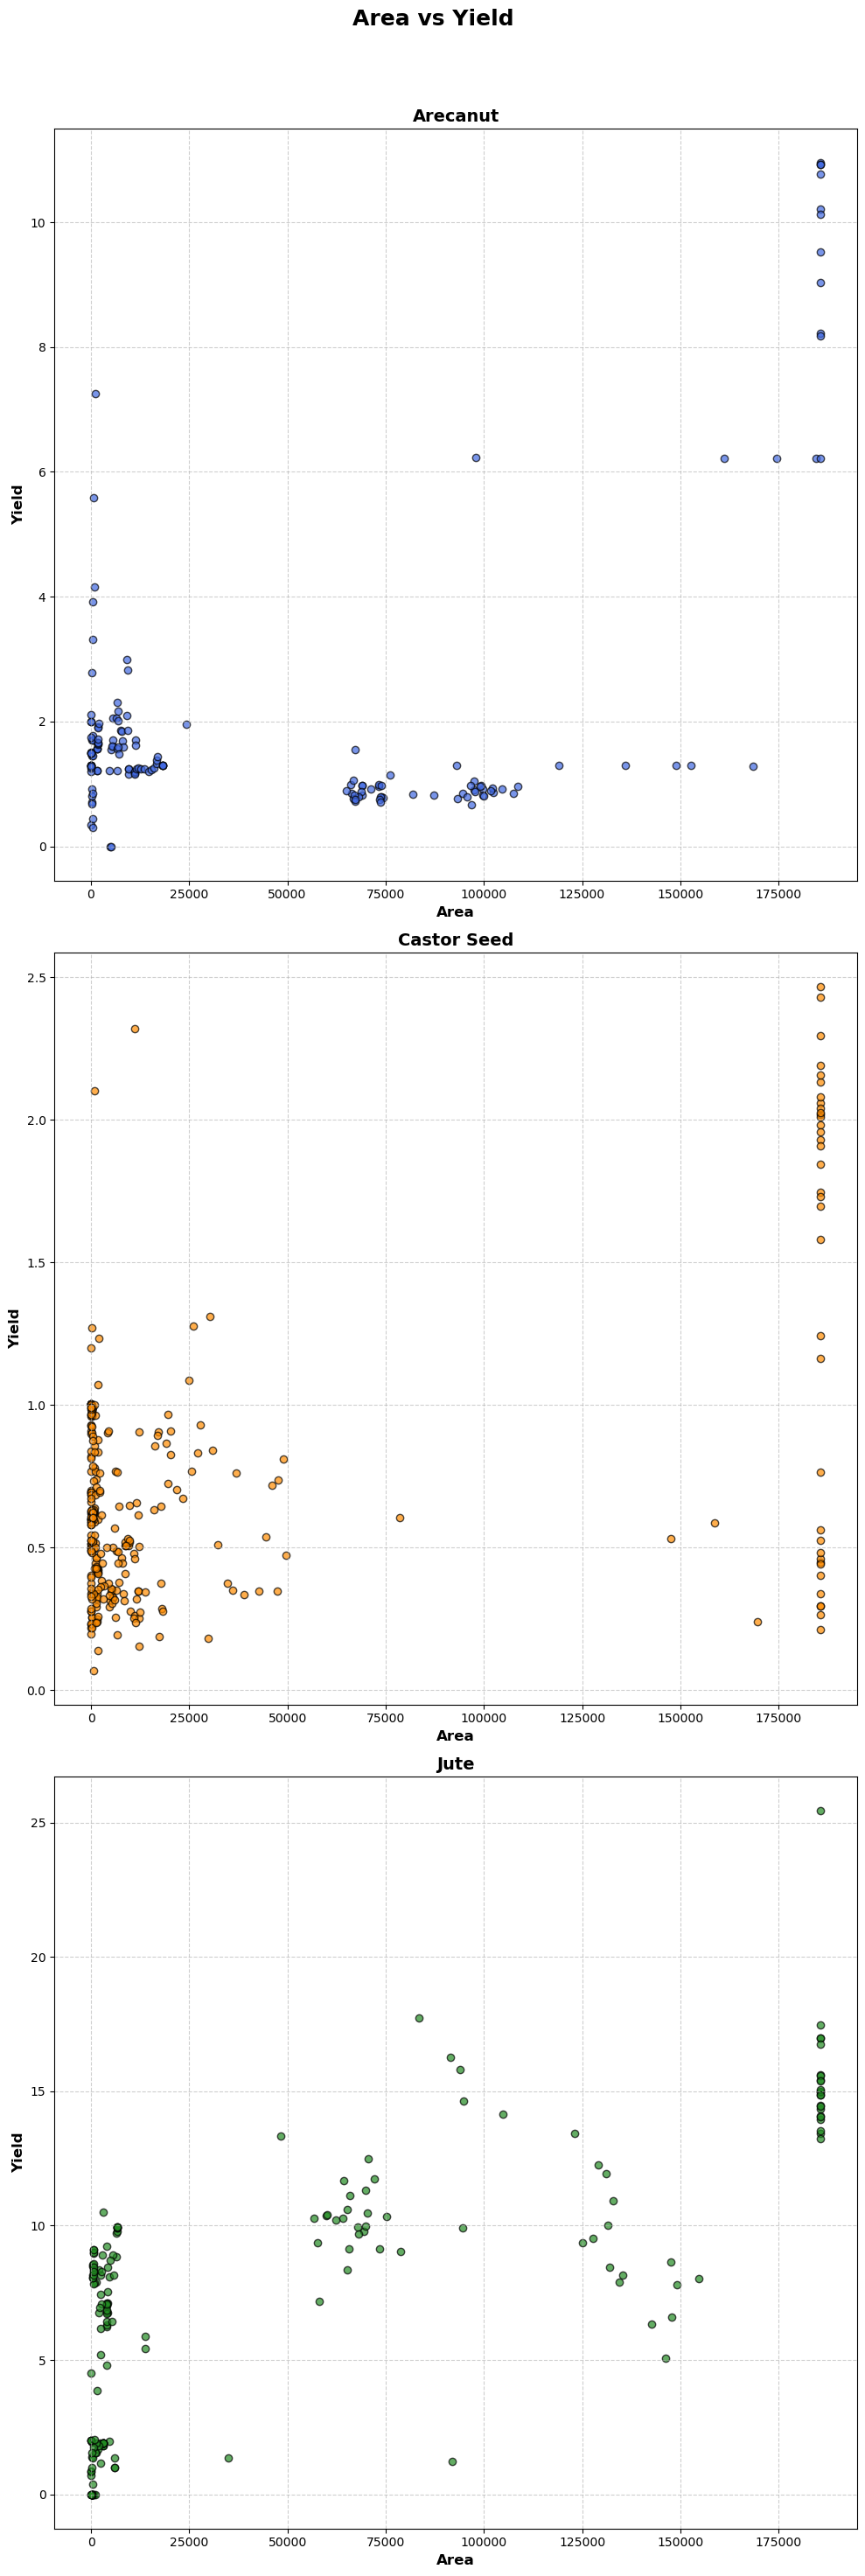

In [ ]:
arecanut_df = crop_dfs['Arecanut']
castor_df = crop_dfs["Castor seed"]
jute_df = crop_dfs["Jute"]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 30))

# Arecanut plot
ax1.scatter(arecanut_df["Area"], arecanut_df["Yield"], color='royalblue', edgecolors='k', alpha=0.7)
ax1.set_xlabel("Area", fontsize=12, fontweight='bold')
ax1.set_ylabel("Yield", fontsize=12, fontweight='bold')
ax1.set_title("Arecanut", fontsize=14, fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.6)

# Castor Seed plot
ax2.scatter(castor_df["Area"], castor_df["Yield"], color='darkorange', edgecolors='k', alpha=0.7)
ax2.set_xlabel("Area", fontsize=12, fontweight='bold')
ax2.set_ylabel("Yield", fontsize=12, fontweight='bold')
ax2.set_title("Castor Seed", fontsize=14, fontweight='bold')
ax2.grid(True, linestyle='--', alpha=0.6)

# Jute plot
ax3.scatter(jute_df["Area"], jute_df["Yield"], color='forestgreen', edgecolors='k', alpha=0.7)
ax3.set_xlabel("Area", fontsize=12, fontweight='bold')
ax3.set_ylabel("Yield", fontsize=12, fontweight='bold')
ax3.set_title("Jute", fontsize=14, fontweight='bold')
ax3.grid(True, linestyle='--', alpha=0.6)

fig.suptitle("Area vs Yield", fontsize=18, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
#Claculating Correaltions
arecanut_area_corr = arecanut_df["Area"].corr(arecanut_df["Yield"])
castor_area_corr = castor_df["Area"].corr(castor_df["Yield"])
jute_area_corr = jute_df["Area"].corr(jute_df["Yield"])
arecanut_area_corr, castor_area_corr, jute_area_corr

(0.5669639564865788, 0.5234030396827707, 0.7218715321825663)

## Fertilizer vs Yield Correlation plot

---

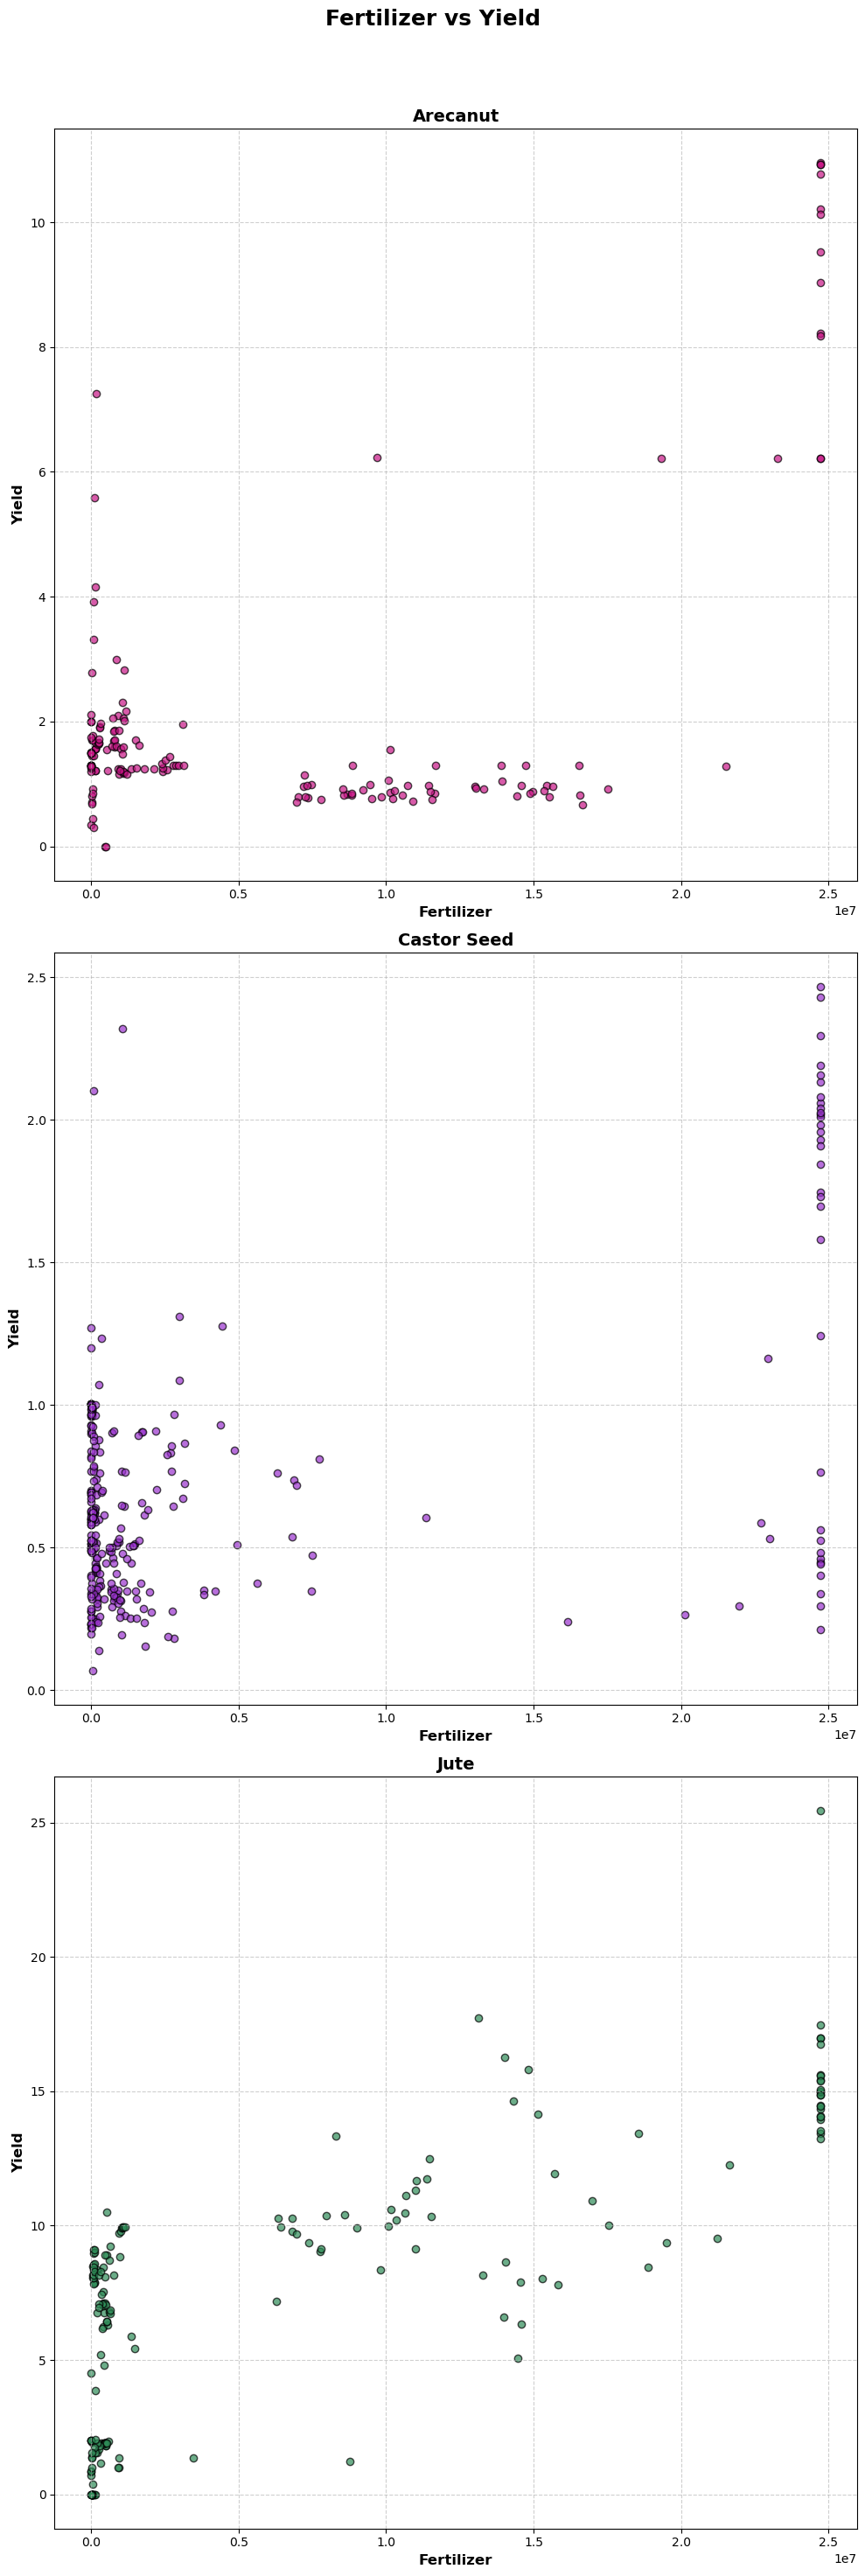

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 30))

# Arecanut plot
ax1.scatter(arecanut_df["Fertilizer"], arecanut_df["Yield"], color='mediumvioletred', edgecolors='k', alpha=0.7)
ax1.set_xlabel("Fertilizer", fontsize=12, fontweight='bold')
ax1.set_ylabel("Yield", fontsize=12, fontweight='bold')
ax1.set_title("Arecanut", fontsize=14, fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.6)

# Castor Seed plot
ax2.scatter(castor_df["Fertilizer"], castor_df["Yield"], color='darkorchid', edgecolors='k', alpha=0.7)
ax2.set_xlabel("Fertilizer", fontsize=12, fontweight='bold')
ax2.set_ylabel("Yield", fontsize=12, fontweight='bold')
ax2.set_title("Castor Seed", fontsize=14, fontweight='bold')
ax2.grid(True, linestyle='--', alpha=0.6)

# Jute plot
ax3.scatter(jute_df["Fertilizer"], jute_df["Yield"], color='seagreen', edgecolors='k', alpha=0.7)
ax3.set_xlabel("Fertilizer", fontsize=12, fontweight='bold')
ax3.set_ylabel("Yield", fontsize=12, fontweight='bold')
ax3.set_title("Jute", fontsize=14, fontweight='bold')
ax3.grid(True, linestyle='--', alpha=0.6)

fig.suptitle("Fertilizer vs Yield", fontsize=18, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
#Calculating Correaltions
arecanut_fertilizer_corr = arecanut_df["Fertilizer"].corr(arecanut_df["Yield"])
castor_fertilizer_corr = castor_df["Fertilizer"].corr(castor_df["Yield"])
jute_fertilizer_corr = jute_df["Fertilizer"].corr(jute_df["Yield"])
arecanut_fertilizer_corr, castor_fertilizer_corr, jute_fertilizer_corr

(0.5704659308944324, 0.5320920379180919, 0.7534890751452589)

## Pesticide vs Yield Correlation plot

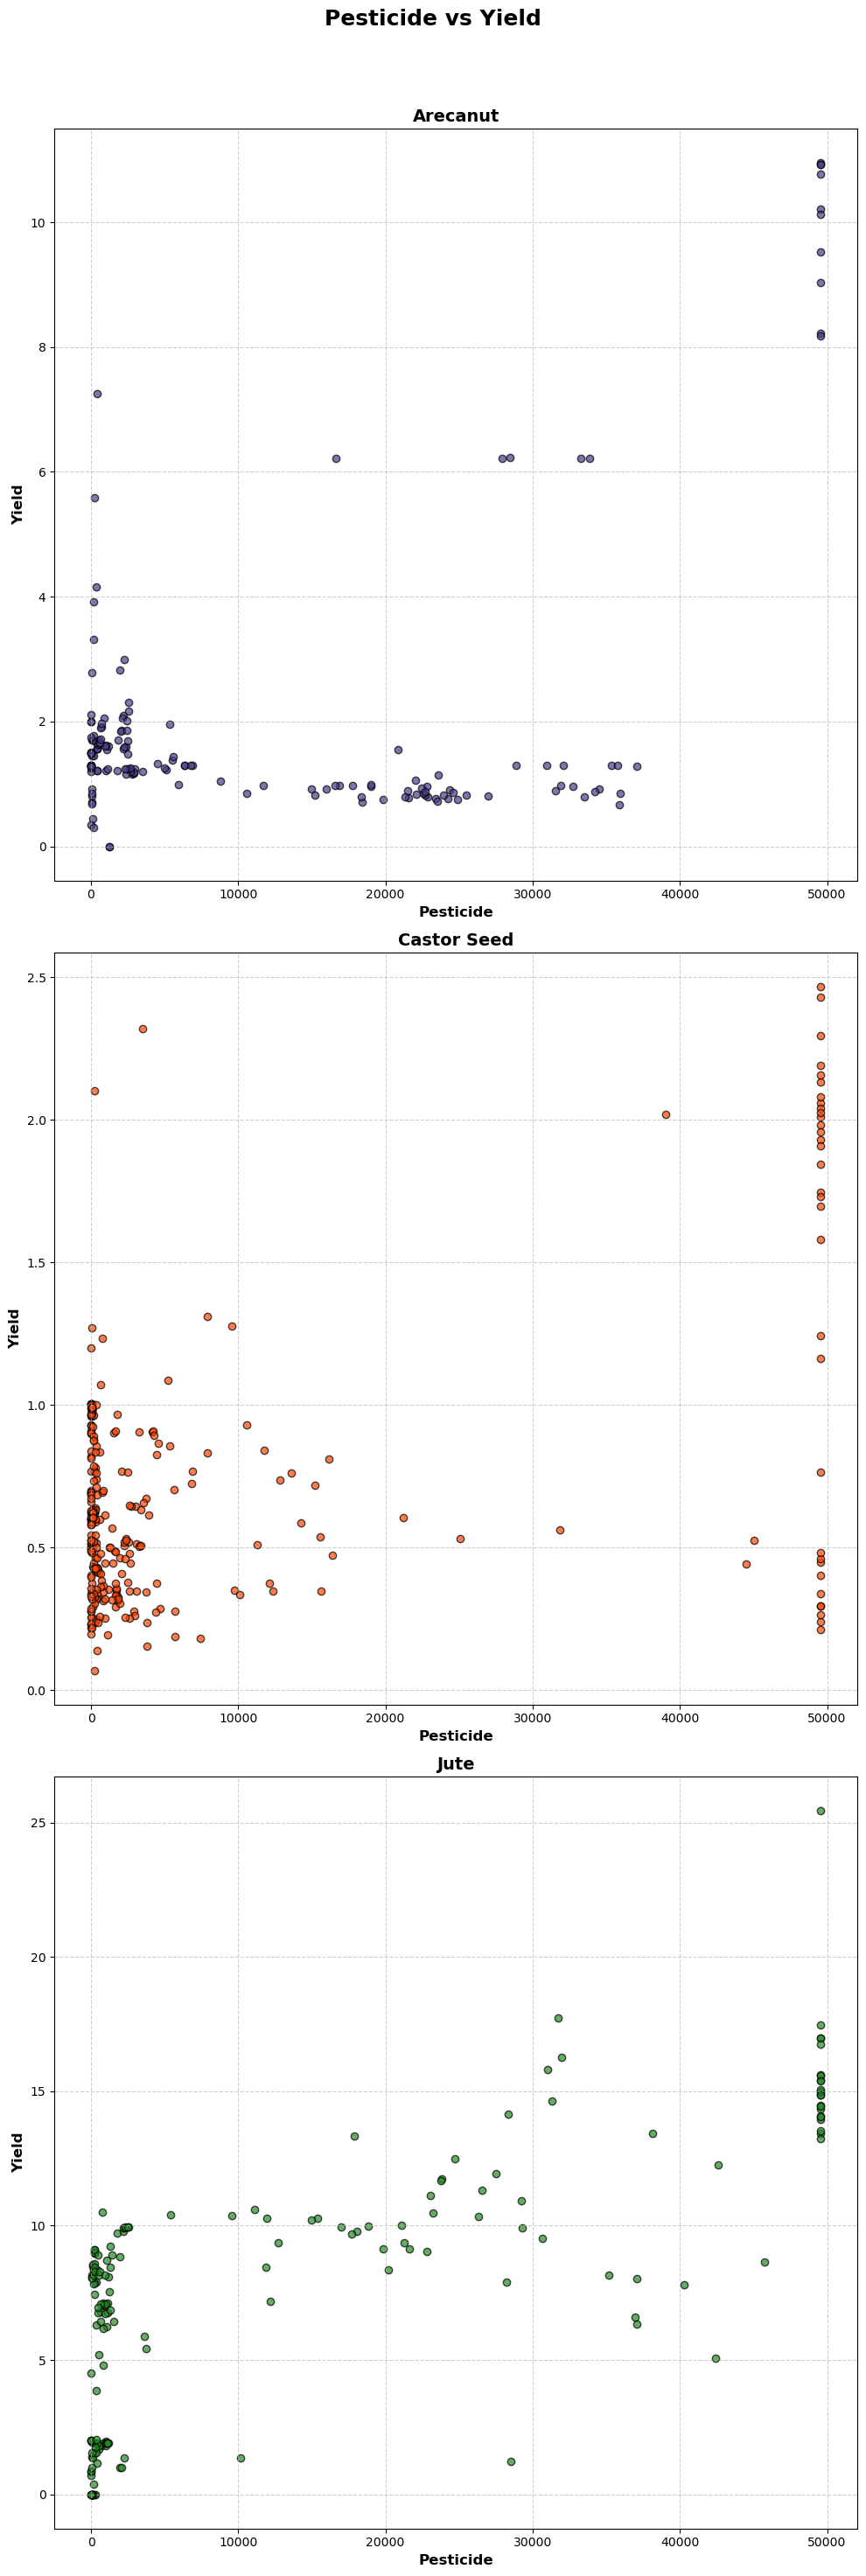

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 30))

# Arecanut plot
ax1.scatter(arecanut_df["Pesticide"], arecanut_df["Yield"], color='darkslateblue', edgecolors='k', alpha=0.7)
ax1.set_xlabel("Pesticide", fontsize=12, fontweight='bold')
ax1.set_ylabel("Yield", fontsize=12, fontweight='bold')
ax1.set_title("Arecanut", fontsize=14, fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.6)

# Castor Seed plot
ax2.scatter(castor_df["Pesticide"], castor_df["Yield"], color='orangered', edgecolors='k', alpha=0.7)
ax2.set_xlabel("Pesticide", fontsize=12, fontweight='bold')
ax2.set_ylabel("Yield", fontsize=12, fontweight='bold')
ax2.set_title("Castor Seed", fontsize=14, fontweight='bold')
ax2.grid(True, linestyle='--', alpha=0.6)

# Jute plot
ax3.scatter(jute_df["Pesticide"], jute_df["Yield"], color='forestgreen', edgecolors='k', alpha=0.7)
ax3.set_xlabel("Pesticide", fontsize=12, fontweight='bold')
ax3.set_ylabel("Yield", fontsize=12, fontweight='bold')
ax3.set_title("Jute", fontsize=14, fontweight='bold')
ax3.grid(True, linestyle='--', alpha=0.6)

fig.suptitle("Pesticide vs Yield", fontsize=18, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
#Calculating Correaltions
arecanut_pesticide_corr = arecanut_df["Pesticide"].corr(arecanut_df["Yield"])
castor_pesticide_corr = castor_df["Pesticide"].corr(castor_df["Yield"])
jute_pesticide_corr = jute_df["Pesticide"].corr(jute_df["Yield"])
arecanut_pesticide_corr, castor_pesticide_corr, jute_pesticide_corr

(0.5342290122340633, 0.5336425551910168, 0.7348385819375495)

### **Regression Analysis**

In [ ]:
X = new_df.drop('Yield', axis=1)
y = new_df["Yield"]
#Splitting off the test set (10% of the total data)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#Splitting the remaining data into training set (80% of total) and validation set (10% of total)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)
# 80% * 0.1111 = 10% (validation)

### Pipeline

In [ ]:
# Categorical and numerical features
categorical_features =['Crop', 'Season', 'State', 'Crop_Year']
numerical_features = ["Area", "Production", "Annual_Rainfall", "Fertilizer", "Pesticide"]

one_hot = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
std_sca = StandardScaler()

transformer = ColumnTransformer([("One_hot", one_hot, categorical_features),
                                 ("std_sca", std_sca, numerical_features)],
                                remainder="passthrough")

In [ ]:
import warnings
warnings.filterwarnings('ignore')

combined_pipeline = Pipeline(steps=[
    ("preprocessor", transformer),
    ("regressor", LinearRegression())
])

ridge_param_dist = {
    "regressor": [Ridge()],
    "regressor__alpha": np.logspace(-2, 1, 3),
}
rf_param_dist = {
    "regressor": [RandomForestRegressor()],
    "regressor__n_estimators": [100, 200],
    "regressor__max_depth": [10, 20]
}

# LinearRegression does not have hyperparameters, so no param grid is needed


linear_search = GridSearchCV(combined_pipeline, param_grid={}, cv=5)
ridge_search = HalvingRandomSearchCV(combined_pipeline, param_distributions=ridge_param_dist, n_candidates=50, cv=5, random_state=42)
rf_search = RandomizedSearchCV(combined_pipeline, param_distributions=rf_param_dist, n_iter=10, cv=5, random_state=42)



linear_search.fit(X_train, y_train)


ridge_search.fit(X_train, y_train)


rf_search.fit(X_train, y_train)



# Output the best models and their parameters
best_models = [
    {"model": linear_search.best_estimator_, "parameters": linear_search.best_params_},
    {"model": ridge_search.best_estimator_, "parameters": ridge_search.best_params_},
    {"model": rf_search.best_estimator_, "parameters": rf_search.best_params_},
]

# Dictionary to hold individual DataFrames for each model
model_metrics_tables = {}

def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):

    y_predt = model.predict(X_train)
    y_pred = model.predict(X_val)
    y_predte = model.predict(X_test)

    mset = mean_squared_error(y_train, y_predt)
    mse = mean_squared_error(y_val, y_pred)
    msete = mean_squared_error(y_test, y_predte)

    maet = mean_absolute_error(y_train, y_predt)
    mae = mean_absolute_error(y_val, y_pred)
    maete = mean_absolute_error(y_test, y_predte)

    r2t = r2_score(y_train, y_predt)
    r2 = r2_score(y_val, y_pred)
    r2te = r2_score(y_test, y_predte)

    rmset = np.sqrt(mset)
    rmse = np.sqrt(mse)
    rmsete = np.sqrt(msete)

    # Creating a new DataFrame to store the metrics for the current model
    metrics_df = pd.DataFrame({
        "Metric": ["MSE", "MAE", "R²", "RMSE"],
        "Train": [mset, maet, r2t, rmset],
        "Validation": [mse, mae, r2, rmse],
        "Test": [msete, maete, r2te, rmsete]
    })

    model_metrics_tables[model_name] = metrics_df

for result in best_models:
    model = result["model"]

    model_name = type(model.named_steps['regressor']).__name__ if 'regressor' in model.named_steps else type(model).__name__

    evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name)


for model_name, metrics_df in model_metrics_tables.items():
    print(f"\nMetrics for {model_name}:")
    print(tabulate(metrics_df, headers='keys', tablefmt='grid', showindex=False))
    print("\n")


Metrics for LinearRegression:
+----------+---------------+--------------+---------------+
| Metric   |         Train |   Validation |          Test |
+==========+===============+==============+===============+
| MSE      | 119982        | 54080.2      | 185427        |
+----------+---------------+--------------+---------------+
| MAE      |     65.2798   |    56.5075   |     76.273    |
+----------+---------------+--------------+---------------+
| R²       |      0.846142 |     0.870821 |      0.818163 |
+----------+---------------+--------------+---------------+
| RMSE     |    346.384    |   232.551    |    430.613    |
+----------+---------------+--------------+---------------+



Metrics for Ridge:
+----------+---------------+--------------+---------------+
| Metric   |         Train |   Validation |          Test |
+==========+===============+==============+===============+
| MSE      | 123321        | 42008.9      | 191555        |
+----------+---------------+--------------+----

### END  ###

### Contributions(Refrences)

1) Dataset Source-: https://www.kaggle.com/datasets/akshatgupta7/crop-yield-in-indian-states-dataset

2) https://scikit-learn.org/1.3/tutorial/machine_learning_map/index.html

3) For Research-: https://www.niti.gov.in/verticals/agriculture

4) For Resaerch-: https://agriwelfare.gov.in/

5) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9894396/


### Insights

Developing the ML model for crop yield prediction deepened our understanding of agricultural data and the various factors affecting crop production. The project helped us apply machine learning to real-world problems, which further enhanced our skills in data preprocessing, model selection, and evaluation. The project also provided valuable insights into how different features like rainfall, fertilizer use, and historical yield data are combined toward predicting the future yields, hence improving our analytical capabilities.

Exploratory Data Analysis (EDA) played a crucial role in this project by allowing us to thoroughly understand the dataset before diving into modeling.

We observed the potential for overfitting when the model complexity was too high, particularly when using models like Random Forests. This highlighted the importance of techniques like cross-validation and hyperparameter tuning to find the right balance between bias and variance.

### Documentation

### Defining Objective:
Our project predicts crop yield using factors like crop type, year, season, state, area, production, rainfall, fertilizer, and pesticide usage, aiming to help farmers optimize resources and plan effectively.

### Importing Necessary Libraries

### Data Acquisition:
The dataset (crop_yield_data.csv) includes vital features: Crop, Year, Season, State, Area, Production, Rainfall, Fertilizer, Pesticide, and Yield (the target variable).

### Data Preprocessing:
It ensures that our data is cleaned, rows with missing values are removed, and only critical features are selected. WE used a preprocessing pipeline that standardizes numeric features i.e. StandardScaler and encoded we our categorical features with OneHotEncoder.


### Creating a pipeline

Creating a single pipeline helped us streamline workflows by automating sequential tasks such as  feature selection, and model training, ensuring consistent data transformations across train, validation and test sets. They also helped us in simplifying hyperparameter.

## Within the Pipeline

### Model Selection

After rigorous walkthrough and much reasoning, we selected and implemented three models for crop yield prediction:

1.	Linear Regression: Chosen for understanding the relationships between variables

   
2.	Ridge Regression: Implemented to prevent overfitting.


3.	Random Forest Regressor: Selected for its robustness in handling diverse agricultural data and capturing non-linear relationships.

### Train-Validation-Test Split:
Our data is split into 80:10:10, training set has 80%, validation size (10%), and test 10% of the sets, ensuring models are rigorously evaluated.

### Hyperparameter Optimization:

We did Hyperparameter tuning to ensure that models capture the data's nuances well and used following search methods RandomizedSearchCV and GridSearchCV for Random Forest and Ridge respectively

### Evaluation:
 We applied 5-fold cross-validation with purpose of ensuring model stability, with metrics such as:

    1.) Median Absolute Error (MedAE): Offers robustness against outliers.
    
    2.)  Mean Squared Error (MSE): Measures average squared errors, emphasizing larger errors.
    
    3.) R-Squared (R²): Indicates how well the model explains variance.

    4.) RMSE-: RMSE measures the square root of the average squared differences between predicted and actual values.
    

### The Random Forest Regressor, balancing these metrics, emerges as the most reliable model for accurate, real-world crop yield predictions.

### Here is the Pseducodes for the The three choosen models

### Linear Regression

BEGIN
     
    LinearRegression(X, y, learning_rate, epochs):
    
    Initialize weights w = [w1, w2, ..., wn] randomly or zeros
    
    Initialize bias b = 0

    FOR epoch in range(epochs):
        predictions = X.dot(w) + b  # Compute predictions for all samples

        errors = predictions - y  # Compute errors

        cost = (1/m) * SUM(errors^2)  # Compute Mean Squared Error

        # Compute gradients
        w_gradient = (2/m) * X.T.dot(errors)
        b_gradient = (2/m) * SUM(errors)

        # Update parameters
        w = w - learning_rate * w_gradient
        b = b - learning_rate * b_gradient

    RETURN w, b  # Return optimized weights and bias
END

### Ridge Regression

BEGIN
    
    RidgeRegression(X, y, learning_rate, epochs, lambda):
    Initialize weights w = [w1, w2, ..., wn] randomly or zeros
    Initialize bias b = 0

    FOR epoch in range(epochs):
        predictions = X.dot(w) + b  # Compute predictions

        errors = predictions - y  # Compute errors

        cost = (1/m) * SUM(errors^2) + lambda * SUM(w^2)  # Compute regularized cost

        # Compute gradients with regularization
        w_gradient = (2/m) * X.T.dot(errors) + 2 * lambda * w
        b_gradient = (2/m) * SUM(errors)

        # Update parameters
        w = w - learning_rate * w_gradient
        b = b - learning_rate * b_gradient

    RETURN w, b  # Return optimized weights and bias
END

### Random Forest Regression

BEGIN
    
    RandomForestRegression(X, y, num_trees, max_features, max_depth):
    Initialize forest = []

    FOR i in range(num_trees):
        # Bootstrap sampling
        X_sample, y_sample = BootstrapSample(X, y)

        # Initialize decision tree
        tree = BuildDecisionTree(X_sample, y_sample, max_features, max_depth)

        # Add tree to forest
        forest.append(tree)

    DEFINE Predict(X_new):
        predictions = []

        FOR tree in forest:
            pred = tree.Predict(X_new)
            predictions.append(pred)

        final_prediction = Mean(predictions)
        RETURN final_prediction
    END

    RETURN Predict  # Return prediction function
END
